# Introduction

In this notebook, i will take a example of how we can extract data from id cards or any paper has a constant form.

Libraries used:
+ pytesseract an python ocr libraries using train model by google. Their repo: https://github.com/madmaze/pytesseract
+ opencv, an python libraries for computer vision.
+ numpy, matplotlib for data preprocessing and visualisation.

# Import libraries

In [1]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt

#Declare pytessecart excuteable path
pytesseract.pytesseract.tesseract_cmd = r'Tesseract-OCR/tesseract'

#My custom class for declare region of interest.
import ImageConstantROI 

#Custom function to show open cv image on notebook.
def display_img(cvImg):
    cvImg = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(cvImg)
    plt.axis('off')
    plt.show()

# Load base image 
Base image is a base form that we select region of interest (an certain of area on image has information we interest). You can view my repo, SelectRoi.py script, to know exactly what i did to select them. It basically using computer mouse manually crop image in help of cv2.SelectRoi function.

My repo link: https://github.com/minhquan23102000/Vietnamese_IdCard_Image_Extraction

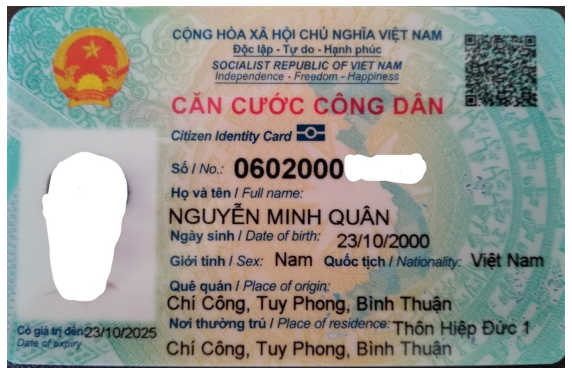

In [5]:
#Loading image using cv2
baseImg = cv2.imread('img/cccd_base.jpg')

#Declare image size, width height and chanel
baseH, baseW, baseC = baseImg.shape

display_img(baseImg)

This is identity card in Viet Nam. In this public notebook, i delete image profile and a little of id numbers to keep privacy. But it would not make any difference in coding steps.

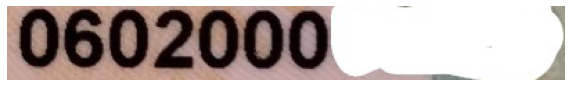

In [6]:
#Create a custom function to cropped image base on religion of interest
def cropImageRoi(image, roi):
    roi_cropped = image[
        int(roi[1]) : int(roi[1] + roi[3]), int(roi[0]) : int(roi[0] + roi[2])
    ]
    return roi_cropped

testCrop = cropImageRoi(baseImg, ImageConstantROI.CCCD.ROIS['id'][0])
display_img(testCrop)

In [7]:
#Extract data from cropped image
pytesseract.image_to_string(testCrop, config='--oem 1 --psm 6')

'0602000 —«\n'

To imporve accuracy of tesseract OCR model, we need to preprocessing image (remove noise, gray scale, threshold, etc)

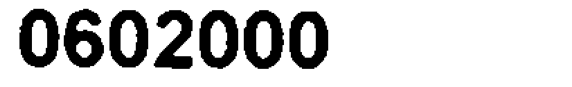

In [8]:
import math
def preprocessing_image(img):

    #img = cv2.resize(img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.multiply(gray, 1.5)
    
    #blur remove noise
    blured1 = cv2.medianBlur(gray,3)
    blured2 = cv2.medianBlur(gray,81)
    divided = np.ma.divide(blured1, blured2).data
    normed = np.uint8(255*divided/divided.max())
    
    
    #Threshold image
    th, threshed = cv2.threshold(normed, 100, 255, cv2.THRESH_OTSU )
    
    return threshed

testPreprocess = preprocessing_image(testCrop)
display_img(testPreprocess)

In [ ]:
#Extract data from cropped image
pytesseract.image_to_string(testCrop, config='--oem 1 --psm 6')

'0602000 —«\n'

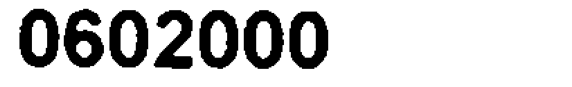

id : 0602000


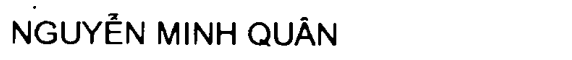

name : NGUYÊN MINH QUÂN


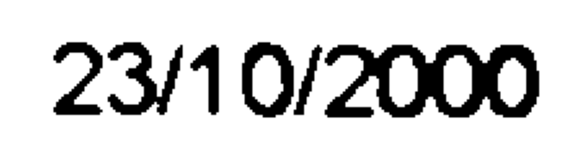

birth_date : 23/10/2000


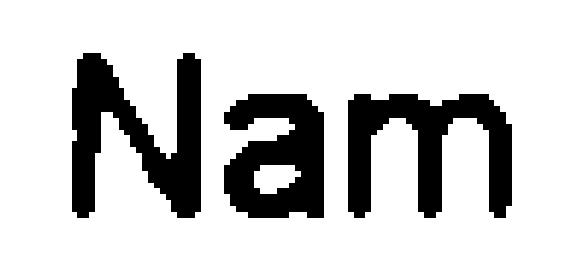

gender : Nam


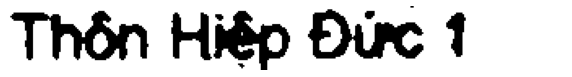

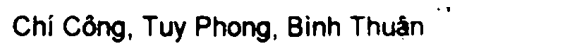

address : Thôn Hiệp Đức 1
 Chí Công, Tuy Phong, Bình Thuận .


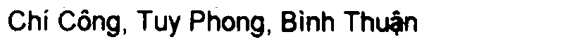

place_birth : Chí Công, Tuy Phong, Bình Thuận


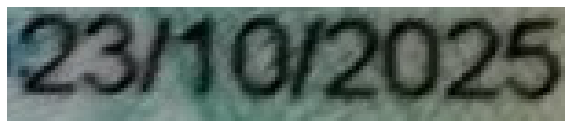

date_expire : 23/10/2025


In [9]:
#Extract all interest data from image
MODEL_CONFIG = '-l vie --oem 1 --psm 6'
for key, roi in ImageConstantROI.CCCD.ROIS.items():
    data = ''
    for r in roi:
        crop_img = cropImageRoi(baseImg, r)
        
        #For a small pxi image only has number, do not preprocessing it is better
        if key != 'date_expire':
            crop_img = preprocessing_image(crop_img)
        
        display_img(crop_img)

        
        data += pytesseract.image_to_string(crop_img, config = MODEL_CONFIG) + ' '
            
    print(f"{key} : {data.strip()}")

In [20]:
#Let create a function to reuse it later
def extractDataFromIdCard(img):
    for key, roi in ImageConstantROI.CCCD.ROIS.items():
        data = ''
        for r in roi:
            crop_img = cropImageRoi(img, r)
            
          
            
            display_img(crop_img)

            #Extract data from image using pytesseract
            data += pytesseract.image_to_string(crop_img, config = MODEL_CONFIG) + ' '
                
        print(f"{key} : {data.strip()}")

# Another Problem
What if we have a different image, with another size (width, height), and another orientation? For example a image show bellow.

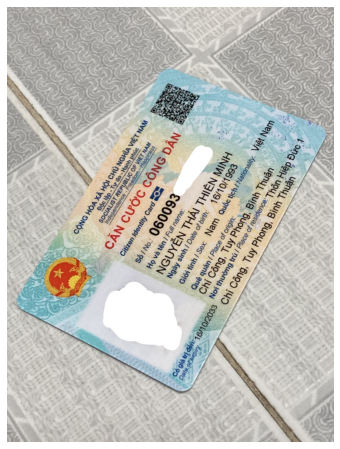

In [11]:
#Load image
img2 = cv2.imread('img/id2.jpg')

display_img(img2)

Well in this situation, we can follow these steps, to transform this image to have a structure, shape like the baseImg that we have selected regions of interest.

+ Step 1: We using ORB, a key points detector from opencv (key points are the points on the image that showing the specified features or stand out points of that image, we using them to find match points of two image) 

+ Step 2: We find matching points of two images and matrix perspective transformation of that image to the base image

+ Step 3: Finally we transform the image to like the baseImg with the matrix perspective transformation we have found.

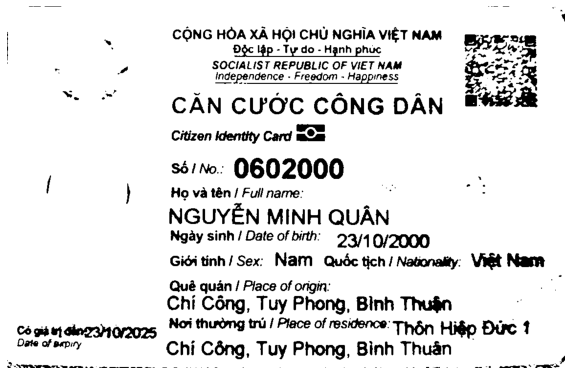

In [12]:
basePreImg = preprocessing_image(baseImg)
display_img(basePreImg)

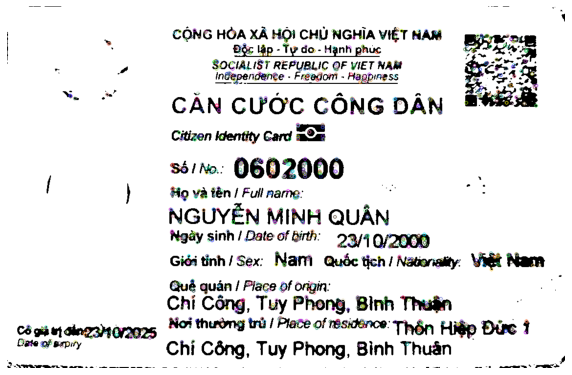

In [13]:
#Init orb, keypoints detection on base Image
orb = cv2.ORB_create(1000)

kp, des = orb.detectAndCompute(basePreImg, None)
imgKp = cv2.drawKeypoints(basePreImg,kp, None)

display_img(imgKp)


Can you see the colorful small points on the image, that is the key points.

In [14]:
img2 = preprocessing_image(img2)

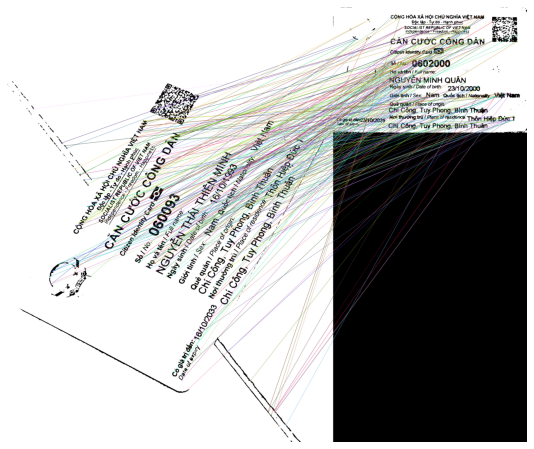

In [16]:
PER_MATCH = 0.25

#Detect keypoint on img2
kp1, des1 = orb.detectAndCompute(img2, None)

#Init BF Matcher, find the matches points of two images
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = list(bf.match(des1, des))

#Select top 30% best matcher 
matches.sort(key=lambda x: x.distance)
best_matches = matches[:int(len(matches)*PER_MATCH)]

#Show match img  
imgMatch = cv2.drawMatches(img2, kp1, basePreImg, kp, best_matches,None, flags=2)
display_img(imgMatch)

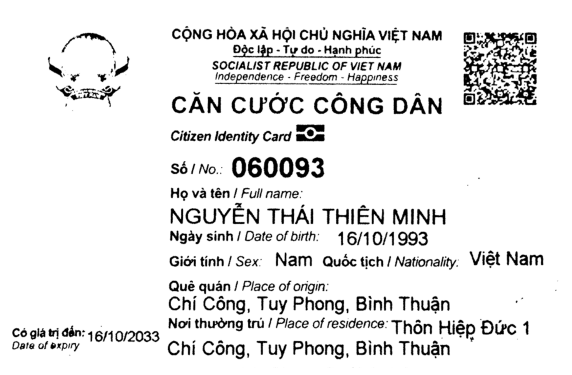

In [17]:
#Init source points and destination points for findHomography function.
srcPoints = np.float32([kp1[m.queryIdx].pt for m in best_matches]).reshape(-1,1,2)
dstPoints = np.float32([kp[m.trainIdx].pt for m in best_matches]).reshape(-1,1,2)


#Find Homography of two images
matrix_relationship, _ = cv2.findHomography(srcPoints, dstPoints,cv2.RANSAC, 5.0)

#Transform the image to have the same structure as the base image
img_final = cv2.warpPerspective(img2, matrix_relationship, (baseW, baseH))

display_img(img_final)

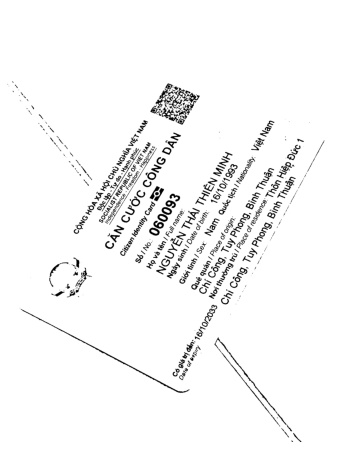

In [18]:
display_img(img2)

Can you see the img2 now has the same stucture as the base Image, now we can feed it to the extract data function we have created to extract information from it.

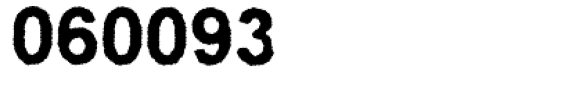

id : 060093


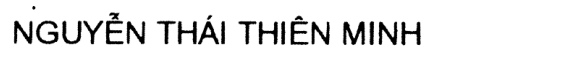

name : NGUYỄN THÁI THIÊN MINH


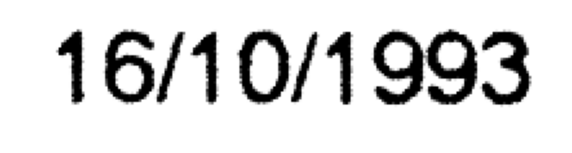

birth_date : 16/10/1993


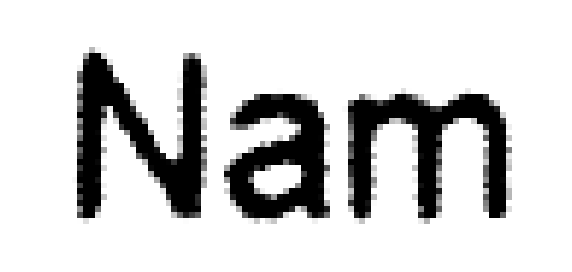

gender : Nam


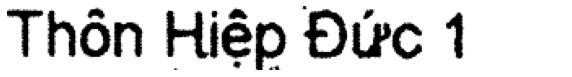

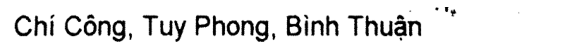

address : Thôn Hiệp Đức 1
 Chí Công, Tuy Phong, Bình Thuận. `


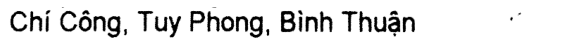

place_birth : Chí Công, Tuy Phong, Bình Thuận u


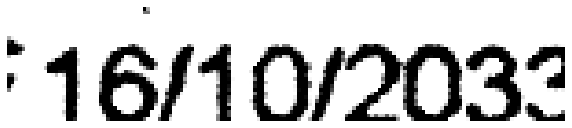

date_expire : 460/10/2033


In [21]:
extractDataFromIdCard(img_final)

Now i think you should have an idea of how to extract data from image. Thanks for reading.

In [24]:
check = cropImageRoi(img_final, ImageConstantROI.CCCD.CHECK_ROI[0])
base = cropImageRoi(basePreImg, ImageConstantROI.CCCD.CHECK_ROI[0])



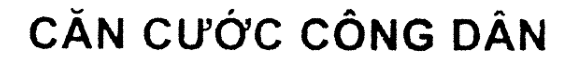

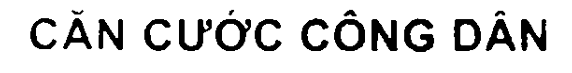

In [25]:
display_img(check)
display_img(base)

In [26]:
check_data, base_data = pytesseract.image_to_string(check, config=MODEL_CONFIG), pytesseract.image_to_string(base,config=MODEL_CONFIG)

In [27]:
check_data.strip(), base_data.strip()

('CĂN CƯỚC CÔNG DÂN', 'CĂN CƯỚC CÔNG DÂN')